<a href="https://colab.research.google.com/github/Muhammad-Daniyal-Imtiaz/Extract-Text-From-Image2/blob/main/Extract-Text-From-Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install opencv-python
!pip install scikit-image
!pip install imutils
!pip install numpy
!pip install  pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


Saving page-scanned.webp to page-scanned (2).webp


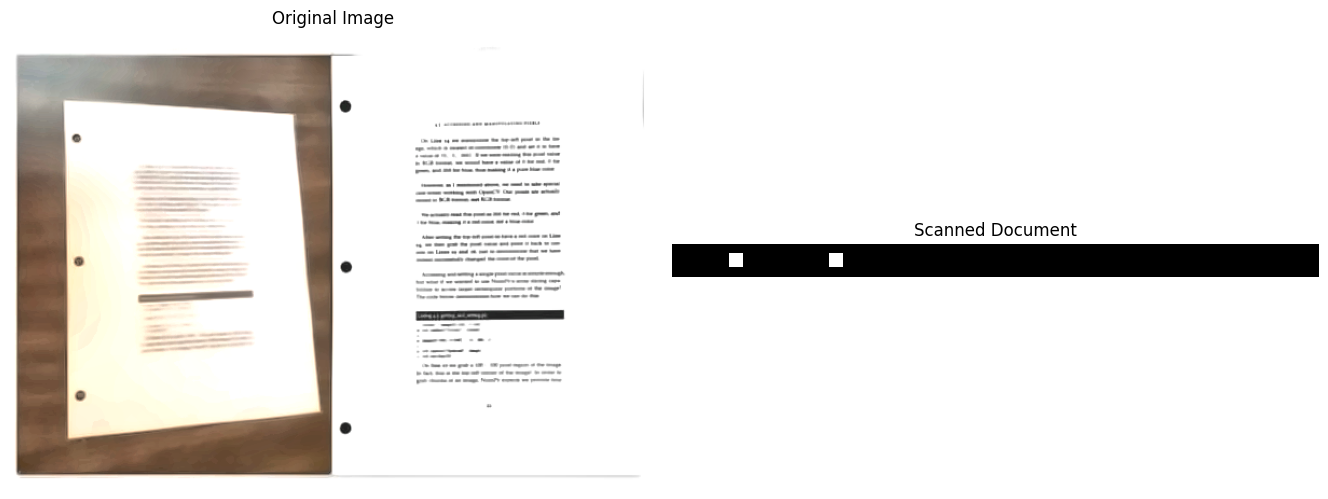


Extracted Text:


Text saved to 'extracted_text.txt'


In [ ]:
import numpy as np
import cv2
import imutils
from skimage.filters import threshold_local
from google.colab.patches import cv2_imshow
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

# Install required packages
!pip install opencv-python scikit-image imutils numpy pytesseract pillow matplotlib

# Initialize pytesseract (for Google Colab)
!sudo apt install tesseract-ocr
!pip install pytesseract

class AdvancedDocumentScanner:
    def __init__(self):
        self.text_blocks = []
        self.enhancement_params = {
            'clahe_clip_limit': 3.0,
            'clahe_grid_size': (8, 8),
            'contrast_alpha': 1.2,
            'brightness_beta': 30,
            'denoise_strength': 10,
            'denoise_template': 7,
            'denoise_search': 21
        }

    def order_points(self, pts):
        """Order points consistently (top-left, top-right, bottom-right, bottom-left)"""
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def four_point_transform(self, image, pts):
        """Apply perspective transform to get top-down view"""
        rect = self.order_points(pts)
        (tl, tr, br, bl) = rect

        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")

        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

        return warped

    def enhance_image(self, image):
        """Advanced image enhancement pipeline"""
        # Denoising
        denoised = cv2.fastNlMeansDenoisingColored(
            image,
            None,
            self.enhancement_params['denoise_strength'],
            self.enhancement_params['denoise_strength'],
            self.enhancement_params['denoise_template'],
            self.enhancement_params['denoise_search']
        )

        # Convert to LAB color space
        lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # CLAHE on L-channel
        clahe = cv2.createCLAHE(
            clipLimit=self.enhancement_params['clahe_clip_limit'],
            tileGridSize=self.enhancement_params['clahe_grid_size']
        )
        cl = clahe.apply(l)

        # Merge channels and convert back to BGR
        limg = cv2.merge((cl, a, b))
        enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        # Contrast stretching
        enhanced = cv2.convertScaleAbs(
            enhanced,
            alpha=self.enhancement_params['contrast_alpha'],
            beta=self.enhancement_params['brightness_beta']
        )

        return enhanced

    def detect_document(self, image):
        """Detect document edges and apply perspective correction"""
        # Edge detection with dynamic thresholds
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Auto Canny edge detection
        sigma = 0.33
        v = np.median(gray)
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        edged = cv2.Canny(gray, lower, upper)

        # Find contours with hierarchy
        cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

        screenCnt = None
        for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                screenCnt = approx
                break

        if screenCnt is None:
            # Fallback: use convex hull of largest contour
            largest_contour = max(cnts, key=cv2.contourArea)
            hull = cv2.convexHull(largest_contour)
            peri = cv2.arcLength(hull, True)
            screenCnt = cv2.approxPolyDP(hull, 0.02 * peri, True)

        return screenCnt

    def binarize_document(self, image):
        """Advanced binarization with text preservation"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Adaptive thresholding with optimized parameters
        binary = cv2.adaptiveThreshold(
            gray,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            21,
            10
        )

        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        return cv2.bitwise_not(binary)

    def analyze_text_blocks(self, image):
        """Detect and analyze text blocks using connected components"""
        # Convert to grayscale and threshold
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Perform connected component analysis
        output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)
        (numLabels, labels, stats, centroids) = output

        # Initialize text block storage
        self.text_blocks = []

        # Loop over the components (skip background)
        for i in range(1, numLabels):
            x, y, w, h, area = stats[i]

            # Filter small components
            if area < 100 or w < 20 or h < 20:
                continue

            # Extract ROI and perform OCR
            roi = image[y:y+h, x:x+w]
            text = pytesseract.image_to_string(roi, config='--psm 6')

            if text.strip():
                self.text_blocks.append({
                    'coordinates': (x, y, w, h),
                    'text': text.strip(),
                    'centroid': centroids[i],
                    'area': area
                })

        return self.text_blocks

    def visualize_results(self, original, scanned, text_blocks=None):
        """Visualize processing results with matplotlib"""
        plt.figure(figsize=(20, 10))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        # Scanned document
        plt.subplot(1, 3, 2)
        plt.imshow(scanned, cmap='gray')
        plt.title("Scanned Document")
        plt.axis('off')

        # Text blocks visualization
        if text_blocks:
            visualization = original.copy()
            for block in text_blocks:
                x, y, w, h = block['coordinates']
                cv2.rectangle(visualization, (x, y), (x+w, y+h), (0, 255, 0), 2)

            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
            plt.title("Detected Text Blocks")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def process_document(self, image_path):
        """Complete document processing pipeline"""
        # Load and enhance image
        image = cv2.imread(image_path)
        enhanced = self.enhance_image(image)

        # Resize for processing
        ratio = image.shape[0] / 500.0
        orig = enhanced.copy()
        resized = imutils.resize(enhanced, height=500)

        # Detect document edges
        screenCnt = self.detect_document(resized)

        # Apply perspective transform
        warped = self.four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

        # Binarize document
        binary = self.binarize_document(warped)

        # Analyze text blocks
        text_blocks = self.analyze_text_blocks(warped)

        # Visualize results
        self.visualize_results(orig, binary, text_blocks)

        # Save results
        cv2.imwrite("scanned_document.jpg", binary)

        # Return structured data
        return {
            'scanned_image': binary,
            'text_blocks': text_blocks,
            'full_text': "\n".join([block['text'] for block in text_blocks])
        }

# Example usage
if __name__ == "__main__":
    # Upload image
    from google.colab import files
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Process document
    scanner = AdvancedDocumentScanner()
    results = scanner.process_document(image_path)

    # Print extracted text
    print("\nExtracted Text:")
    print("="*50)
    print(results['full_text'])
    print("="*50)

    # Save text to file
    with open("extracted_text.txt", "w") as f:
        f.write(results['full_text'])
    print("\nText saved to 'extracted_text.txt'")

# **New Section**